In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST  # or FashionMNIST
from torchvision.transforms import ToTensor

device = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(train:bool):
    data = MNIST(
        root="data",
        train=train,
        transform=ToTensor(),
        download=True)
    return data

trainset = load_data(True)
testset = load_data(False)

trainset, testset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

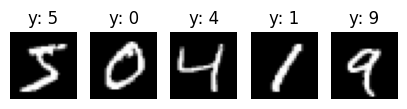

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure(figsize=(5, 1))

n_samples = 5
for i in range(n_samples):
    img, lbl = trainset[i]  # img: tensor(1, 28, 28), lbl: int
    img = img.squeeze()  # (1, 28, 28) -> (28, 28)
    img = img.numpy()
    plt.subplot(1, 5, i+1)
    plt.axis("off")
    plt.title(f"y: {lbl}")
    plt.imshow(img, cmap="gray")
plt.show()

In [4]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()  # (1, 28, 28) -> (784,)
        self.fc_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.fc_stack(x)
        return logits

DNN()

DNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [5]:
def train(model, dataloader, loss_fn, optimizer):
    model.train()
    n_samples = len(dataloader.dataset)
    
    for batch_i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_ = model(X)  # predict

        loss = loss_fn(y_, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_i % 100 == 0:
            loss = loss.item()
            prog = batch_i * len(X)
            print(f"Loss: {loss:>7f}, Progress: {prog:>5d}/{n_samples:>5d}")

In [6]:
def test(model, dataloader, loss_fn):
    model.eval()
    n_samples = len(dataloader.dataset)
    
    total_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_ = model(X)  # predict

            total_loss += loss_fn(y_, y).item()
            correct += (y_.argmax(1) == y).type(torch.float).sum().item()
    
    accuracy = correct / n_samples
    avg_loss = total_loss / n_samples
    print(f"Accuracy: {accuracy:>7f}, Avg_Loss: {avg_loss:>7f}")

In [7]:
# model
model = DNN().to(device)

# hyper-parameters
epochs = 10
batch_size = 64
lr = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

# data
trainset_loader = DataLoader(trainset, batch_size)
testset_loader = DataLoader(testset, batch_size)

In [8]:
# train & test
for epoch_i in range(epochs):
    print(f"Epoch: {epoch_i + 1} -----")
    train(model, trainset_loader, loss_fn, optimizer)
    test(model, testset_loader, loss_fn)
print("done.")

Epoch: 1 -----
Loss: 2.312645, Progress:     0/60000
Loss: 0.251361, Progress:  6400/60000
Loss: 0.198211, Progress: 12800/60000
Loss: 0.235531, Progress: 19200/60000
Loss: 0.133853, Progress: 25600/60000
Loss: 0.320116, Progress: 32000/60000
Loss: 0.153561, Progress: 38400/60000
Loss: 0.233679, Progress: 44800/60000
Loss: 0.376818, Progress: 51200/60000
Loss: 0.149478, Progress: 57600/60000
Accuracy: 0.956300, Avg_Loss: 0.002140
Epoch: 2 -----
Loss: 0.075030, Progress:     0/60000
Loss: 0.081513, Progress:  6400/60000
Loss: 0.133088, Progress: 12800/60000
Loss: 0.085945, Progress: 19200/60000
Loss: 0.046468, Progress: 25600/60000
Loss: 0.097750, Progress: 32000/60000
Loss: 0.050291, Progress: 38400/60000
Loss: 0.130152, Progress: 44800/60000
Loss: 0.142568, Progress: 51200/60000
Loss: 0.123359, Progress: 57600/60000
Accuracy: 0.967200, Avg_Loss: 0.001681
Epoch: 3 -----
Loss: 0.047153, Progress:     0/60000
Loss: 0.058063, Progress:  6400/60000
Loss: 0.050337, Progress: 12800/60000
Los

In [9]:
# saving model
pth = "dnn.pth"
torch.save(model.state_dict(), pth)
print(f"Saved model: {pth}")

Saved model: dnn.pth


In [10]:
# loading model
model = DNN()
model.load_state_dict(torch.load(pth))
model.eval()

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",]

X, y = testset[0]
with torch.no_grad():
    pred = model(X)
    y_, y = classes[pred[0].argmax(0)], classes[y]
    print(f"Predicted: {y_}, Actual: {y}")

Predicted: Sneaker, Actual: Sneaker
